In [1]:
#https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env ROCM_PATH=/opt/rocm
import tensorflow as tf
tf.test.is_built_with_rocm()
# document export HSA_OVERRIDE_GFX_VERSION=10.3.0
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

env: HSA_OVERRIDE_GFX_VERSION=10.3.0
env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: ROCM_PATH=/opt/rocm


2023-03-19 09:21:05.519721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 09:21:05.563712: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-19 09:21:06.366200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-03-19 09:21:06.366220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diag

In [12]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [13]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

In [14]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599


INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Total number of images : 202599
Found 202599 images belonging to 1 classes.


In [15]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

2023-03-19 09:40:36.128153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )

In [18]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0   

In [19]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)

simple_autoencoder.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                                 callbacks=[checkpoint_ae])

/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_3105712/421804079.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  simple_autoencoder.fit_generator(data_flow,


Epoch 1/10
396/395 [==============================] - ETA: 0s - loss: 0.0289
Epoch 1: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 207s 522ms/step - loss: 0.0289
Epoch 2/10
396/395 [==============================] - ETA: 0s - loss: 0.0107
Epoch 2: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 211s 532ms/step - loss: 0.0107
Epoch 3/10
396/395 [==============================] - ETA: 0s - loss: 0.0090
Epoch 3: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 215s 542ms/step - loss: 0.0090
Epoch 4/10
396/395 [==============================] - ETA: 0s - loss: 0.0083
Epoch 4: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 223s 563ms/step - loss: 0.0083
Epoch 5/10
396/395 [==============================] - ETA: 0s - loss: 0.0079
Epoch 5: saving model to ./weights/AE/weights.h5
395/395 [==============================] - 219s 552ms/step - loss: 0.0079


1/1 [==============================] - 0s 127ms/step


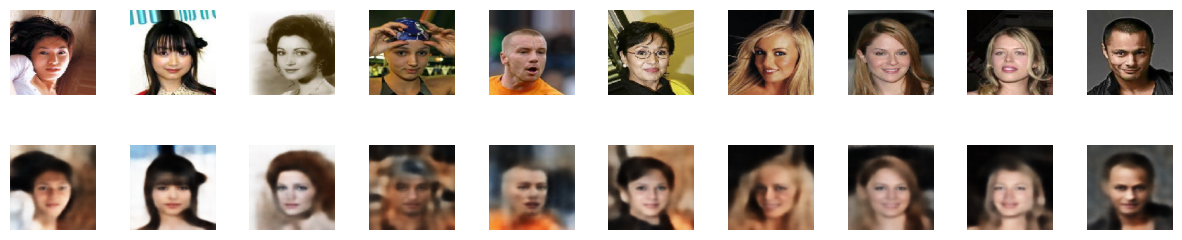

In [20]:
import matplotlib.pyplot as plt

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

def plot_compare(images=None, add_noise=False):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

plot_compare(example_images)      



1/1 [==============================] - 0s 80ms/step


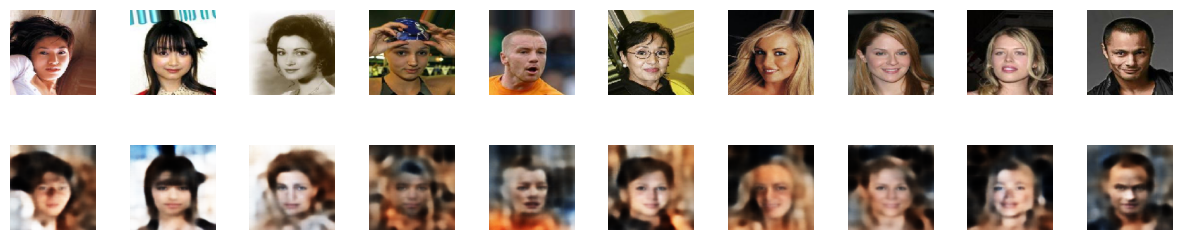

In [21]:
plot_compare(images = example_images, add_noise = True)

1/1 [==============================] - 0s 16ms/step


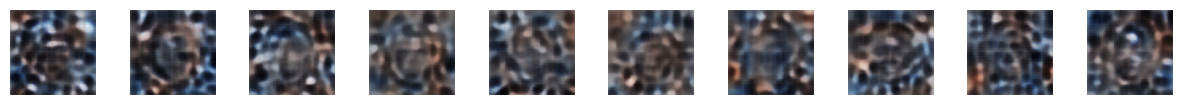

In [22]:
def generate_images_from_noise(n_to_show = 10): 
  reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

generate_images_from_noise()  